In [1]:
import numpy as np

import sklearn.linear_model
import sklearn.model_selection

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sbs

from Decoders import *
import util.FileIO as FileIO

Text(0, 0.5, 'Predicted BG')

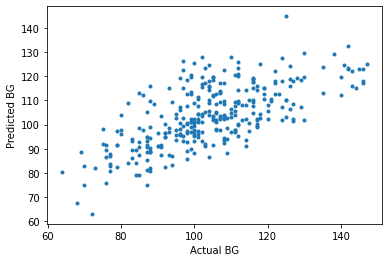

In [2]:
# Optimize the decoders with ALL regions

# Directory Info
data_dir = './'
pt = 'Data'
anat_fname = 'anatInfo.mat'
data_fname = 'linkedData-0.mat'
filter_bg = True
filter_gm = True

# Import files
(anat_mat,linkedTime,linkedBG,linkedTF) = FileIO.load_files(pt,data_dir=data_dir)
    
# Filter out only grey matter indices
gm_idx = np.sort(anat_mat['anatIdx']['gm'][0,0].T[0]) - 1 # Need to subtract 1 since it's MATLAB indices
linkedTF = linkedTF[:,gm_idx,:]
    
    
# Reshape matrix into all observations/channels
linkedTF_flattened = np.reshape(linkedTF,[linkedTF.shape[0],-1])
N_TF = linkedTF_flattened.shape[1]
N_timepoints = linkedTF_flattened.shape[0]
    
# Split into the training and test set
linkedTF_train,linkedTF_test,linkedBG_train,linkedBG_test = sklearn.model_selection.train_test_split(linkedTF_flattened, linkedBG, test_size=0.2)
    
# Train Decoder
alpha = 0.103 # Alpha chosen from K=fold validation on a training set.
model = sklearn.linear_model.LassoLars(alpha=alpha,normalize=False)
decoder = GlucoseDecoder(model)
(preds,preds_corrected,rvalue) = decoder.fit_model(linkedTF_train,linkedBG_train)

# Now test on testing set
pred_BG = decoder.predict(linkedTF_test)
plt.plot(linkedBG_test,pred_BG,'.')
plt.xlabel('Actual BG')
plt.ylabel('Predicted BG')